In [ ]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def input_set_up(spectro, ms): 
    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

In [3]:
# Variables
tone = 1000
angle = 0
max_ild = 2
time_sim = 100 #us

In [4]:
# Variables dependant on tone
tone_error = 20

x = [100,1000, 10000]
y = [10, 10, 0.1]
p = np.polyfit(x, np.log(y), 1)
a = np.exp(p[1])
b = p[0]
C_m_bushy = a * np.exp(b * tone)
C_m_bushy = 1

In [5]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

ANFs2SBCs_weight = 2.0
ANFs2GBCs_weight = 1.0
GBCs2MNTBCs_weight = 16.0
SBCs2MSO_weight = 4.0
MNTBCs2MSO_weights = [0.0, -2.0, -4.0, -6.0, -8.0, -10.0, -12.0, -14.0, -16.0, -20.0]
n_battery = len(MNTBCs2MSO_weights)
#SBCs2LSO_weight = 16.0
#MNTBCs2LSO_weight = -2.0

delay_inh = 0.1

mean_rate = 0
mean_amplitude = 1000
noise_rate = 20

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)
n_MSOs = n_GBCs*n_battery

In [6]:
freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
spectro = np.zeros((3500,time_sim))
channels = len(freq[np.where((freq>tone-tone_error) & (freq<tone+tone_error))])
amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, channels) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2)
spectro[np.where(freq>tone-tone_error)[0][0]:np.where((freq<tone+tone_error))[0][-1] + 1, :] = amplitudes.reshape(channels,1)*np.ones((channels, 100))

In [7]:
delta_x = (w_head*np.sin(np.deg2rad(angle)))
itd = 1000*delta_x/v_sound #ms
ipds = 2*np.pi*itd*freq/1000
ild = angle*max_ild/90

In [2]:
r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
            params={'frequency': np.repeat(freq, 10),
                    'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

r_ANFs = nest.Create('parrot_neuron', n_ANFs)

r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

r_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
            params={'frequency': np.repeat(freq, 10),
                'phase': 0})

l_ANFs = nest.Create('parrot_neuron',n_ANFs)

l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

l_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                 params = {'C_m': C_m_bushy, 'V_m': -70})

ANFs_noise = nest.Create('poisson_generator',1,
                 params = {'rate':noise_rate})

s_rec_r = nest.Create('spike_recorder')
s_rec_l = nest.Create('spike_recorder')

nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

nest.Connect(r_MSO, s_rec_r, 'all_to_all')
nest.Connect(l_MSO, s_rec_l, 'all_to_all')

for i in range(len(spectro)-1):
    if(np.any(spectro[i][:] > 0)):
        nest.Connect(ANFs_noise, r_ANFs[10*i:10*(i+1)], 'all_to_all')
        nest.Connect(ANFs_noise, l_ANFs[10*i:10*(i+1)], 'all_to_all')
        
for i in range(n_SBCs):
    nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
    nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

for i in range(n_GBCs):
    nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
    nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

for i in range(n_GBCs):
    for j in range(n_battery):
        nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
        nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight}) 
        nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
        nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight}) 
    
nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})
nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})

for i in range(n_GBCs):
    for j in range(n_battery):
        nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delay_inh})
        nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delay_inh})

multi = nest.Create('multimeter', 1, {'record_from': ['V_m']})
nest.SetStatus(multi, {'interval': 0.01})
nest.Connect(multi, r_MSO,'all_to_all')
#nest.Connect(multi, l_MSO,'all_to_all')


if(angle>=0): 
    mean_amplitude_r = mean_amplitude
    mean_amplitude_l = mean_amplitude/(10**(abs(ild)/20))
else:
    mean_amplitude_l = mean_amplitude
    mean_amplitude_r = mean_amplitude/(10**(abs(ild)/20))
    
for i in range(time_sim):
    input_set_up(spectro,i)
    nest.Simulate(1)

NameError: name 'nest' is not defined

In [1]:
data_r = s_rec_r.get('events')
data_l = s_rec_l.get('events')
data_mso = multi.get('events')

id_r_ANF1 = r_ANFs[0].get('global_id')
id_r_SBC1 = r_SBCs[0].get('global_id')
id_r_GBC1 = r_GBCs[0].get('global_id')
id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
id_r_MSO1 = r_MSO[0].get('global_id')

id_l_ANF1 = l_ANFs[0].get('global_id')
id_l_SBC1 = l_SBCs[0].get('global_id')
id_l_GBC1 = l_GBCs[0].get('global_id')
id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
id_l_MSO1 = l_MSO[0].get('global_id')

NameError: name 's_rec_r' is not defined

In [10]:
active_r_ANFs = np.unique(data_r['senders'][np.where(data_r['senders']<id_r_SBC1)], return_counts = True)[0]
active_r_SBCs = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))], return_counts = True)[0]
active_r_GBCs = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))], return_counts = True)[0]
active_r_MNTBCs = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))], return_counts = True)[0]
active_r_MSOs = np.unique(data_r['senders'][np.where(data_r['senders']>=id_r_MSO1)], return_counts = True)[0]

In [11]:
active_l_ANFs = np.unique(data_l['senders'][np.where(data_l['senders']<id_l_SBC1)], return_counts = True)[0]
active_l_SBCs = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))], return_counts = True)[0]
active_l_GBCs = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))], return_counts = True)[0]
active_l_MNTBCs = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))], return_counts = True)[0]
active_l_MSOs = np.unique(data_l['senders'][np.where(data_l['senders']>=id_l_MSO1)], return_counts = True)[0]

In [12]:
bin_dim = 0.8 #ms

rate_r_ANFs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_ANFs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_ANFs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,100,bin_dim))
    rate_r_ANFs = rate_r_ANFs + s_r
    
for i in active_l_ANFs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,100,bin_dim))
    rate_l_ANFs = rate_l_ANFs + s_l
    
rate_r_ANFs = rate_r_ANFs/len(active_r_ANFs)
rate_l_ANFs = rate_l_ANFs/len(active_l_ANFs)
    
rate_r_SBCs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_SBCs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_SBCs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,100,bin_dim))
    rate_r_SBCs = rate_r_SBCs + s_r
    
for i in active_l_SBCs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,100,bin_dim))
    rate_l_SBCs = rate_l_SBCs + s_l
    
rate_r_SBCs = rate_r_SBCs/len(active_r_SBCs)
rate_l_SBCs = rate_l_SBCs/len(active_l_SBCs)
    
rate_r_GBCs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_GBCs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_GBCs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,100,bin_dim))
    rate_r_GBCs = rate_r_GBCs + s_r
    
for i in active_l_GBCs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,100,bin_dim))
    rate_l_GBCs = rate_l_GBCs + s_l
    
rate_r_GBCs = rate_r_GBCs/len(active_r_GBCs)
rate_l_GBCs = rate_l_GBCs/len(active_l_GBCs)

rate_r_MNTBCs = np.zeros(int(time_sim/bin_dim)-1)
rate_l_MNTBCs = np.zeros(int(time_sim/bin_dim)-1)

for i in active_r_MNTBCs:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,100,bin_dim))
    rate_r_MNTBCs = rate_r_MNTBCs + s_r
    
for i in active_l_MNTBCs:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,100,bin_dim))
    rate_l_MNTBCs = rate_l_MNTBCs + s_l

rate_r_MNTBCs = rate_r_MNTBCs/len(active_r_MNTBCs)
rate_l_MNTBCs = rate_l_MNTBCs/len(active_l_MNTBCs)

In [13]:
rate_r_MSOs = np.zeros((n_battery, int(time_sim/bin_dim)-1))
rate_l_MSOs = np.zeros((n_battery, int(time_sim/bin_dim)-1))
count_r = 0
count_l = 0

for i in range(int(n_MSOs/n_battery)):
    rate_old = rate_r_MSOs.sum()
    for j in range(n_battery):
        t_r = data_r['times'][np.where(data_r['senders'] == r_MSO[i*n_battery + j])]
        s_r, bins = np.histogram(t_r, np.arange(0,100,bin_dim))
        rate_r_MSOs[j] = rate_r_MSOs[j] + s_r
    if(np.sum(rate_r_MSOs) != rate_old):
        count_r = count_r + 1
        
for i in range(int(n_MSOs/n_battery)):
    rate_old = rate_l_MSOs.sum()
    for j in range(n_battery):
        t_l = data_l['times'][np.where(data_l['senders'] == l_MSO[i*n_battery + j])]
        s_l, bins = np.histogram(t_l, np.arange(0,100,bin_dim))
        rate_l_MSOs[j] = rate_l_MSOs[j] + s_l
    if(np.sum(rate_l_MSOs) != rate_old):
        count_l = count_l + 1
        
rate_r_MSOs = rate_r_MSOs/count_r
rate_l_MSOs = rate_l_MSOs/count_l

In [14]:
rate_r_MSO_battery = np.zeros(n_battery)
rate_l_MSO_battery = np.zeros(n_battery)

for j in range(n_battery):
    if((86331 + j) in data_r['senders']):
        rate_r_MSO_battery[j] = (np.unique(data_r['senders'][np.where(data_r['senders'] == 86331 + j)], return_counts= True)[1][0])/time_sim*1000
    else:
        rate_r_MSO_battery[j] = 0
        
    if((186081 + j) in data_l['senders']):
        rate_l_MSO_battery[j] = (np.unique(data_l['senders'][np.where(data_l['senders'] == 186081 + j)], return_counts= True)[1][0])/time_sim*1000
    else:
        rate_l_MSO_battery[j] = 0

In [15]:
results_r_MSO = np.zeros((n_battery, 10))
results_r_MSO[:, 1] = rate_r_MSO_battery

In [16]:
results_r_MSO

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:

np.savetxt('rate_r_MSO_avg_battery_angle_{}_freq_{}'.format(angle, tone), rate_r_MSO_avg_battery)
np.savetxt('rate_l_MSO_avg_battery_angle_{}_freq_{}'.format(angle, tone), rate_l_MSO_avg_battery)

np.savetxt('rate_r_MSO_battery_angle_{}_freq_{}'.format(angle, tone), rate_r_MSO_battery)
np.savetxt('rate_l_MSO_battery_angle_{}_freq_{}'.format(angle, tone), rate_l_MSO_battery)

results_r_MSO[:, np.where[angles == angle]] = rate_r_MSO_battery
results_l_MSO[:, np.where[angles == angle]] = rate_l_MSO_battery


NameError: name 'rate_r_MSO_avg_battery' is not defined

Text(0.5, 0, 'Time (ms)')

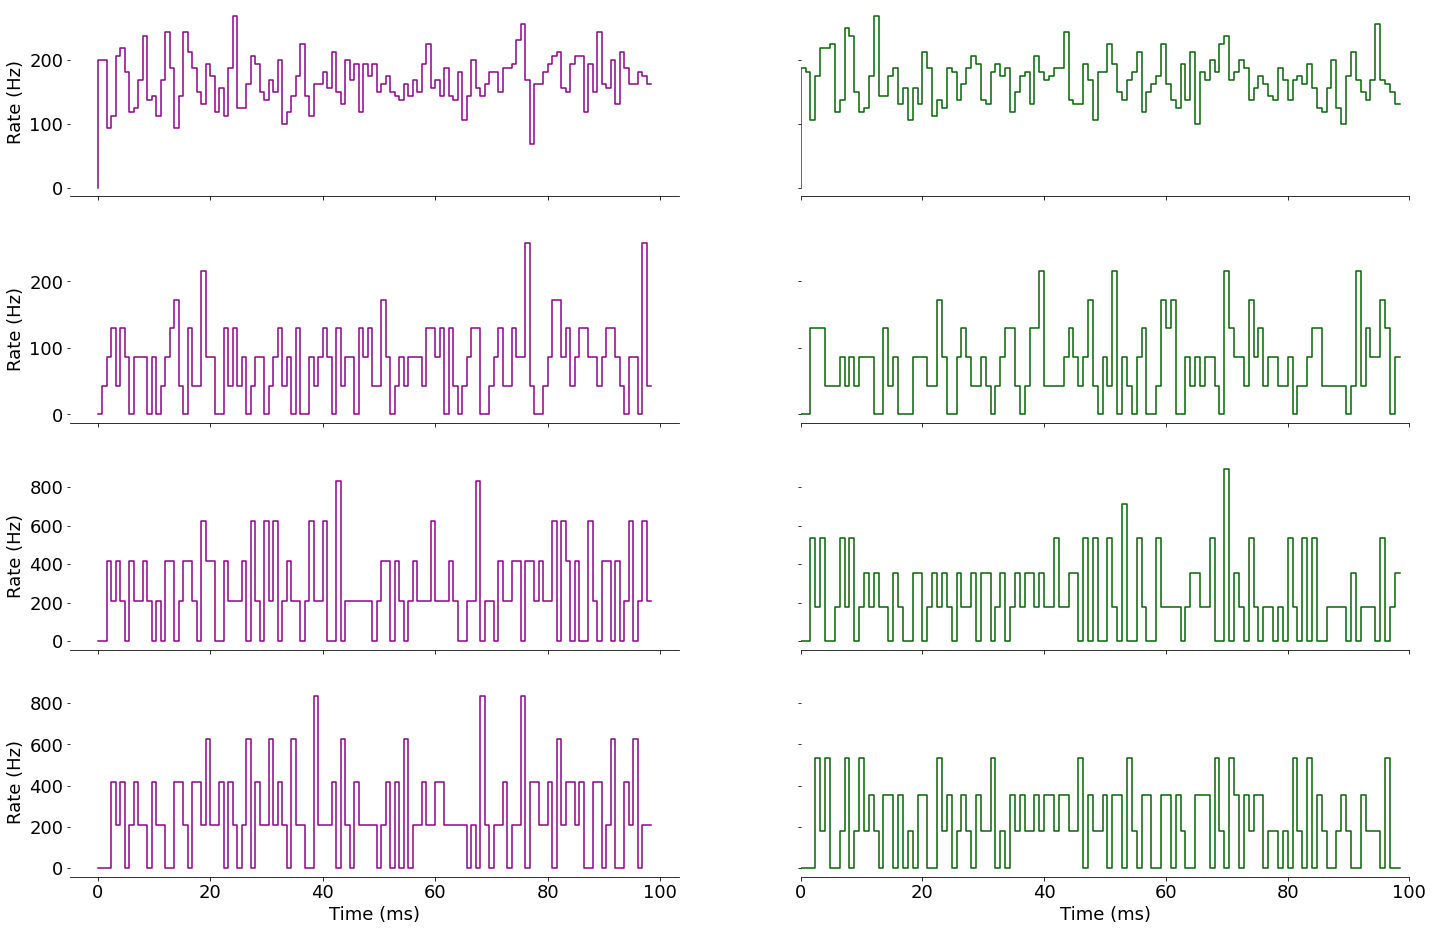

In [18]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], rate_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate (Hz)")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], rate_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate (Hz)")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], rate_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate (Hz)")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], rate_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate (Hz)")
ax[3,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], rate_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], rate_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], rate_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], rate_r_MNTBCs*1000/bin_dim, color = 'darkgreen')
ax[3,1].set_xlabel("Time (ms)")

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].plot(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)], data_l['senders'][np.where(data_l['senders'] < id_l_SBC1)] - id_l_ANF1 + id_r_ANF1, ".", color = 'darkmagenta')
ax[0,0].set_ylabel("Rate (Hz)")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]  - id_l_SBC1 + id_r_SBC1, ".", color = 'darkmagenta')
ax[1,0].set_ylabel("Rate (Hz)")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]  - id_l_GBC1 + id_r_GBC1, ".", color = 'darkmagenta')
ax[2,0].set_ylabel("Rate (Hz)")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))] - id_l_MNTBC1 + id_r_MNTBC1, ".", color = 'darkmagenta')
ax[3,0].set_ylabel("Rate (Hz)")
ax[3,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].plot(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)], data_r['senders'][np.where(data_r['senders'] < id_r_SBC1)], ".", color = 'darkgreen')
ax[0,1].set_ylabel("Rate (Hz)")

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], ".", color = 'darkgreen')
ax[1,1].set_ylabel("Rate (Hz)")

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], ".", color = 'darkgreen')
ax[2,1].set_ylabel("Rate (Hz)")

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], ".", color = 'darkgreen')
ax[3,1].set_ylabel("Rate (Hz)")
ax[3,1].set_xlabel("Time (ms)")

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(1,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,time_sim)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].plot(data_r['times'][np.where(data_r['senders'] > id_r_MSO1)], data_r['senders'][np.where(data_r['senders'] > id_r_MSO1)], ".", color = 'darkgreen')
ax[0].set_ylabel("Rate (Hz)")

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].plot(data_l['times'][np.where(data_l['senders'] > id_l_MSO1)], data_l['senders'][np.where(data_l['senders'] > id_l_MSO1)] - id_l_ANF1 + id_r_ANF1, ".", color = 'darkmagenta')
ax[1].set_ylabel("Rate (Hz)")



In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(n_battery,2, figsize = (24,16), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

for i in range(n_battery):
    ax[i,0].spines['top'].set_visible(False)
    ax[i,0].spines['right'].set_visible(False)
    ax[i,0].spines['left'].set_visible(False)
    ax[i,0].step(bins[:-1], rate_l_MSOs[i]*1000/bin_dim, color = 'darkmagenta')
    ax[i,0].set_ylabel("{} nS".format(MNTBCs2MSO_weights[i]), rotation = 1, fontsize=20, labelpad=20)
    
    ax[i,1].spines['top'].set_visible(False)
    ax[i,1].spines['right'].set_visible(False)
    ax[i,1].spines['left'].set_visible(False)
    ax[i,1].step(bins[:-1], rate_r_MSOs[i]*1000/bin_dim, color = 'darkgreen')

# Choice of a single battery

In [ ]:
active_r_MSOs

In [ ]:
active_l_MSOs

In [ ]:
first_active_battery_r = int((active_r_MSOs[0] - id_r_MSO1)/n_battery)
first_active_battery_l = int((active_l_MSOs[0] - id_l_MSO1)/n_battery)
last_active_battery_r = int((active_r_MSOs[-1] - id_r_MSO1)/n_battery)
last_active_battery_l = int((active_l_MSOs[-1] - id_l_MSO1)/n_battery)

In [ ]:
battery = r_MSO[86331-id_r_MSO1:86341-id_r_MSO1]

In [ ]:
battery2 = r_MSO[86321-id_r_MSO1:86331-id_r_MSO1]

In [ ]:
colors = ['c', 'deepskyblue', 'royalblue']
fig, ax = plt.subplots(1, figsize=(8,7), sharey = True)

text_color = 'k' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='k')
ax.yaxis.label.set_color('k')
ax.tick_params(axis='y', colors='k')


ax.axhline(y = battery[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")
ax.plot(data_mso['times'][np.where(data_mso['senders'] == battery[0].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] == battery[0].get('global_id'))], color = 'k', label = 'No Inhibition')
ax.plot(data_mso['times'][np.where(data_mso['senders'] == battery[1].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] ==battery[1].get('global_id'))], color = 'deepskyblue', label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[1]))
ax.plot(data_mso['times'][np.where(data_mso['senders'] == battery[9].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] ==battery[9].get('global_id'))], color = 'royalblue', label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[9]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(4,10)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
fig.legend()

In [ ]:
colors = ['c', 'deepskyblue', 'royalblue']
fig, ax = plt.subplots(1, figsize=(8,7), sharey = True)

text_color = 'k' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='k')
ax.yaxis.label.set_color('k')
ax.tick_params(axis='y', colors='k')


ax.axhline(y = battery2[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")
ax.plot(data_mso['times'][np.where(data_mso['senders'] == battery2[0].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] == battery2[0].get('global_id'))], color = 'k', label = 'No Inhibition')
ax.plot(data_mso['times'][np.where(data_mso['senders'] == battery2[1].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] ==battery2[1].get('global_id'))], color = 'deepskyblue', label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[1]))
ax.plot(data_mso['times'][np.where(data_mso['senders'] == battery2[9].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] ==battery2[9].get('global_id'))], color = 'royalblue', label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[9]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(4,10)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
fig.legend()

In [ ]:
fig, ax = plt.subplots(11,1, figsize=(24,16))
colors = ['k', 'deepskyblue', 'dodgerblue', 'royalblue', 'steelblue', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
for i in range(n_battery-1):
    ax[0].plot(data_mso['times'][np.where(data_mso['senders'] == battery[i].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] == battery[i].get('global_id'))], color = colors[i])
    ax[0].set_xticks(np.arange(0,100,10))
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel("Vm [mV]")

for i in range(0,n_battery):
    ax[i+1].spines['top'].set_visible(False), 
    ax[i+1].spines['right'].set_visible(False)
    ax[i+1].plot(data_mso['times'][np.where(data_mso['senders'] == battery[i].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] == battery[i].get('global_id'))], color = colors[i])
    ax[i+1].axhline(y = r_MSO[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")
    ax[i+1].plot(data_r['times'][np.where(data_r['senders'] == battery[i].get('global_id'))],  -55*np.ones(len(data_r['times'][np.where(data_r['senders'] == battery[i].get('global_id'))])), color = 'k', marker = '*', ms = 14, linestyle = 'None', label = "Spikes")
    ax[i+1].set_ylabel("{} nS".format(MNTBCs2MSO_weights[i]), rotation = 1, fontsize=20, labelpad=20)
    ax[i+1].set_xticks(np.arange(0,100,10))
    ax[i+1].set_yticklabels([])
ax[i+1].set_xlabel("Time [ms]")
handles, labels = ax[i+1].get_legend_handles_labels()
fig.legend(handles, labels, loc=2)

In [ ]:
fig, ax = plt.subplots(11,1, figsize=(24,16))
colors = ['k', 'deepskyblue', 'dodgerblue', 'royalblue', 'steelblue', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
for i in range(n_battery-1):
    ax[0].plot(data_mso['times'][np.where(data_mso['senders'] == battery[i].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] == battery[i].get('global_id'))], color = colors[i])
    ax[0].set_xticks(np.arange(0,100,10))
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel("Vm [mV]")

for i in range(0,n_battery):
    ax[i+1].spines['top'].set_visible(False), 
    ax[i+1].spines['right'].set_visible(False)
    ax[i+1].plot(data_mso['times'][np.where(data_mso['senders'] == battery[i].get('global_id'))], data_mso['V_m'][np.where(data_mso['senders'] == battery[i].get('global_id'))], color = colors[i])
    ax[i+1].axhline(y = r_MSO[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")
    ax[i+1].plot(data_r['times'][np.where(data_r['senders'] == battery[i].get('global_id'))],  -55*np.ones(len(data_r['times'][np.where(data_r['senders'] == battery[i].get('global_id'))])), color = 'k', marker = '*', ms = 14, linestyle = 'None', label = "Spikes")
    ax[i+1].set_ylabel("{} nS".format(MNTBCs2MSO_weights[i]), rotation = 1, fontsize=20, labelpad=20)
    ax[i+1].set_xticks(np.arange(0,100,10))
    ax[i+1].set_yticklabels([])
ax[i+1].set_xlabel("Time [ms]")
handles, labels = ax[i+1].get_legend_handles_labels()
fig.legend(handles, labels, loc=2)

In [ ]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

fig, ax = plt.subplots(1, figsize = (12,5), sharex = 'col', sharey = 'row')
plt.xlim(0,time_sim)

for i in range(n_battery):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(data_r['times'][np.where(data_r['senders'] == battery[i].get('global_id'))], data_r['senders'][np.where(data_r['senders'] == battery[i].get('global_id'))], ".", ms = 14, color = 'darkgreen')